In [1]:
!pip install pygam

In [2]:
!pip install ISLP

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [4]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

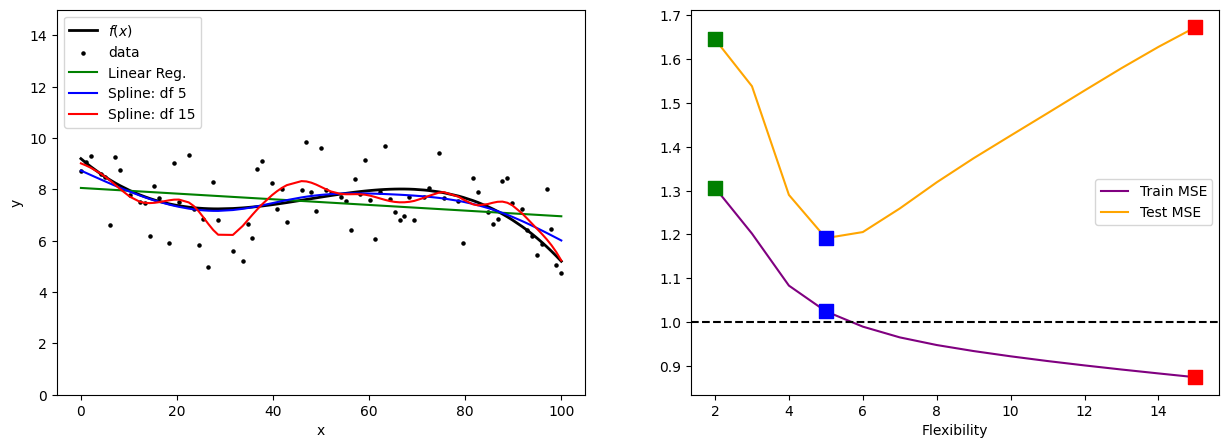

In [5]:
def f(x):
    return 9.2 - 0.16 * x + 0.004 * (x**2) - 0.000028 * (x**3)

sig2e = 1.0
x = np.linspace(-1, 100, 100)
np.random.seed(7)
y = f(x) + np.random.normal(scale=sig2e, size=len(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_idx_tr = x_train.argsort()
x_idx_te = x_test.argsort()
x_train = x_train[x_idx_tr]
x_test = x_test[x_idx_te]
y_train = y_train[x_idx_tr]
y_test = y_test[x_idx_te]

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_test = x_test[:, np.newaxis]

# degrees of freedom range
max_deg = 15
df_range = np.arange(2, max_deg)
all_df_range = np.arange(2, max_deg + 1)

# plot function
lw = 2
model_colors = ["black", "green", "blue", "red"]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_prop_cycle(
    color=model_colors
)
ax[0].plot(x_train, f(x_train), linewidth=lw, label="$f(x)$")

# plot training points
ax[0].scatter(x_train, y_train, label="data", s=5)

# linear model
model = LinearRegression()
model.fit(X_train, y_train)

y_plot = model.predict(X_train)
ax[0].plot(x_train, y_plot, label="Linear Reg.")
train_losses = [np.mean((y_train - y_plot)**2)]
test_losses = [np.mean((y_test - model.predict(X_test))**2)]

# Smoothing-spline with df degrees of freedom
gam = LinearGAM(s_gam(0, lam=0.1))
gam.fit(X_train, y_train)
x_term = gam.terms[0]

for df in df_range:
    lam = approx_lam(X_train, x_term, df+1)
    x_term.lam = lam
    model = make_pipeline(gam)
    model.fit(X_train, y_train)
    y_plot = model.predict(X_train)
    train_losses.append(np.mean((y_train - y_plot)**2))
    test_losses.append(np.mean((y_test - model.predict(X_test))**2))
    if df in [4, max_deg - 1]:
      ax[0].plot(x_train, y_plot, label=f"Spline: df {df + 1}")

ax[0].legend(loc="upper left")
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim(0, 15)

pnts = np.array([1, 4, max_deg - 1])
ax[1].plot(all_df_range, train_losses, label= 'Train MSE', color = "purple")
ax[1].scatter(pnts + 1, np.array(train_losses)[pnts - 1], color = model_colors[1:], marker='s', s=100, zorder=2)
ax[1].plot(all_df_range, test_losses, label= 'Test MSE', color = 'orange')
ax[1].scatter(pnts + 1, np.array(test_losses)[pnts - 1], color = model_colors[1:], marker='s', s=100, zorder=2)
ax[1].axhline(y=sig2e, color='k', linestyle='--')
ax[1].set_xlabel('Flexibility')
ax[1].legend(loc="center right")
plt.show()